In [358]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [359]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    sx = sigmoid(x)
    return sx * (1 - sx)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [360]:
class NN:
    def __init__(self, input_shape, hidden1_shape, hidden2_shape, output_shape):
        self.w1 = np.random.uniform(size=(input_shape, hidden1_shape))
        self.w2 = np.random.uniform(size=(hidden1_shape, hidden2_shape))
        self.w3 = np.random.uniform(size=(hidden2_shape, output_shape))
        self.b1 = np.random.uniform(size=(1, hidden1_shape))
        self.b2 = np.random.uniform(size=(1, hidden2_shape))
        self.b3 = np.random.uniform(size=(1, output_shape))

        # Placeholders for intermediate values

        self.z1 = None
        self.z2 = None
        self.z3 = None
        self.o1 = None
        self.o2 = None
        self.o3 = None

    def forward(self, x):
        self.z1 = np.matmul(x, self.w1) + self.b1
        self.o1 = relu(self.z1)
        self.z2 = np.matmul(self.o1, self.w2) + self.b2
        self.o2 = relu(self.z2)
        self.z3 = np.matmul(self.o2, self.w3) + self.b3
        self.o3 = sigmoid(self.z3)
        return self.o3

In [361]:
class DQN:
    def __init__(self):
        self.model = NN(1 , 64 , 64 , 1)
        self.lr = 0.001
        self.start_epsilon = 0.5
        self.end_epsilon = 0.01
        self.epsilon_decay = 0.999
        self.gamma = 0.9
        self.clip_value = 1.0
    
    def predict(self, state):
        self.start_epsilon = max(self.end_epsilon, self.start_epsilon * self.epsilon_decay)
        output = self.model.forward(state)
        return float(output[0, 0] > 0.5) if np.random.rand() > self.start_epsilon else np.random.choice([0, 1])

    def reset_epsilon(self):
        self.start_epsilon = 0.5

    def update(self, r, d, q_current, s_):
        q_target = r if d else r + self.gamma * self.model.forward(s_)

        # Use MSE loss
        # Layer 3(output layer)
        delta3 = (q_target - q_current) * sigmoid_derivative(self.model.o3)
        delta3 = np.clip(delta3, -self.clip_value, self.clip_value)
        self.model.w3 -= self.lr * delta3 * self.model.o2.T
        self.model.b3 -= self.lr * delta3

        # Layer 2
        delta2 = (self.model.w3 @ delta3.T).T * relu_derivative(self.model.z2)
        delta2 = np.clip(delta2, -self.clip_value, self.clip_value)
        self.model.w2 -= self.lr * self.model.o1.T @ delta2
        self.model.b2 -= self.lr * delta2

        # Layer 1
        delta1 = (delta2 @ self.model.w2.T) * relu_derivative(self.model.z1)
        delta1 = np.clip(delta1, -self.clip_value, self.clip_value)
        self.model.w1 -= self.lr * s_.T @ delta1
        self.model.b1 -= self.lr * delta1

    def save_model(self, filename):
        np.savez_compressed(filename,
                            w1=self.model.w1, w2=self.model.w2, w3=self.model.w3,
                            b1=self.model.b1, b2=self.model.b2, b3=self.model.b3)
    
    def load_model(self, filename):
        filepath = Path(filename)
        if filepath.is_file():
            data = np.load(filepath)
            self.model.w1 = data['w1']
            self.model.w2 = data['w2']
            self.model.w3 = data['w3']
            self.model.b1 = data['b1']
            self.model.b2 = data['b2']
            self.model.b3 = data['b3']

In [362]:
class game_theory:
    def __init__(self):
        self.score_a_list = [0]
        self.score_b_list = [0]
    
    def play(self, a , b):
        if a:
            if b:
                self.score_a_list.append(3)
                self.score_b_list.append(3)
            else:
                self.score_a_list.append(0)
                self.score_b_list.append(5)
        else:
            if b:
                self.score_a_list.append(5)
                self.score_b_list.append(0)
            else:
                self.score_a_list.append(1)
                self.score_b_list.append(1)
    
    def check_winner(self):
        score_a = sum(self.score_a_list)
        score_b = sum(self.score_b_list)
        if score_a > score_b:
            return "A wins"
        elif score_b > score_a:
            return "B wins"
        else:
            return "Draw"

In [363]:
def get_hostility(a ,b):
    return (sum(a) - sum(b)) * 0.2, (sum(b) - sum(a)) * 0.2

Final Scores:
Agent A: 102082
Agent B: 102227
Result: B wins


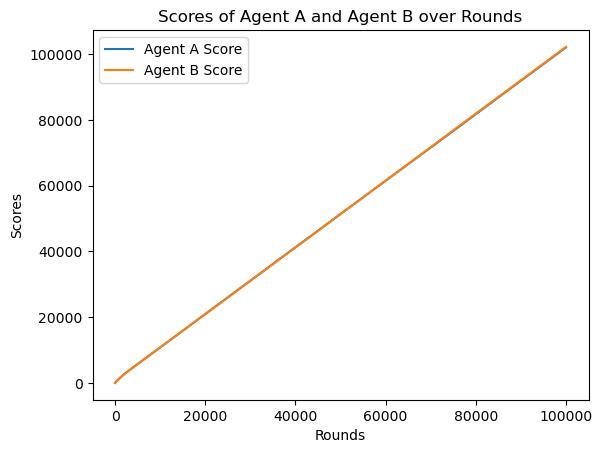

In [364]:
def main():
    agent1 = DQN()
    agent2 = DQN()
    # agent3 = DQN()

    agent1.load_model("agent1_model.npz")
    agent2.load_model("agent2_model.npz")
    # agent3.load_model("agent3_model.npz")
    
    game = game_theory()

    hostility_a = 0
    hostility_b = 0

    plot_a = []
    plot_b = []

    done_check = False

    loop_time = 100_000

    for i in range(loop_time):
        reward_a = game.score_a_list[-1]
        reward_b = game.score_b_list[-1]

        if i == loop_time - 1:
            done_check = True
            if game.check_winner() == "A wins":
                reward_a = 10
                reward_b = -10
            elif game.check_winner() == "B wins":
                reward_a = -10
                reward_b = 10
            else:
                reward_a = 5
                reward_b = 5
            
        output_a = agent1.predict(np.array([[hostility_a]]))
        output_b = agent2.predict(np.array([[hostility_b]]))
        game.play(output_a, output_b)
        hostility_a, hostility_b = get_hostility(game.score_a_list, game.score_b_list)
        q_current_a = agent1.model.forward(np.array([[hostility_a]]))
        q_current_b = agent2.model.forward(np.array([[hostility_b]]))
        agent1.update(r=reward_a, d=done_check, q_current=q_current_a, s_=np.array([[hostility_a]]))
        agent2.update(r=reward_b, d=done_check, q_current=q_current_b, s_=np.array([[hostility_b]]))
        plot_a.append(sum(game.score_a_list))
        plot_b.append(sum(game.score_b_list))

    print("Final Scores:")
    print("Agent A:", sum(game.score_a_list))
    print("Agent B:", sum(game.score_b_list))
    print("Result:", game.check_winner())

    agent1.reset_epsilon()
    agent2.reset_epsilon()

    agent1.save_model("agent1_model.npz")
    agent2.save_model("agent2_model.npz")

    plt.plot(plot_a, label='Agent A Score')
    plt.plot(plot_b, label='Agent B Score')
    plt.xlabel('Rounds')
    plt.ylabel('Scores')
    plt.title('Scores of Agent A and Agent B over Rounds')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()